<a href="https://colab.research.google.com/github/mitali-g/MachineLearning/blob/master/SqeezeNet_Chest_Xray_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Input, GlobalAveragePooling2D, BatchNormalization, concatenate
from keras.utils import np_utils
import os, cv2, random
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [ ]:
!unzip -q Resized_Dataset.zip

In [45]:
!ls Resized_Dataset/train-resized|wc

   5309    5309  137840


In [3]:
dataset = pd.read_csv("Resized_Dataset/Chest_xray_Corona_Metadata.csv")
print(dataset.shape)
dataset.head(5932)

(5910, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [34]:
dataset = dataset[['X_ray_image_name', 'Label']]

In [38]:
x_train_features = dataset[['X_ray_image_name']]
x_train_features = x_train_features[0:5309]
#print(x_train_features)

In [37]:
y_train_labels = dataset[['Label']]
y_train_labels = y_train_labels[0:5309]
#print(y_train_labels)

In [39]:
from sklearn.utils import shuffle
train_dataset = dataset[0:5309]
test_dataset = dataset[5309:]

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

In [40]:
x_train_features = train_dataset['X_ray_image_name']
y_train_labels = train_dataset['Label']

In [19]:
y_train = []
for label in y_train_labels:
  if label == 'Pnemonia':
    y_train.append(1)
  elif label == 'Normal':
    y_train.append(0)
  else:
    print(label)
#print(y_train)
y_train = keras.utils.to_categorical(y_train)
print(y_train)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [41]:
x_test_features = dataset[['X_ray_image_name']]
x_test_features = x_test_features[5309:]
#print(x_test_features)

In [42]:
y_test_labels = dataset[['Label']]
y_test_labels = y_test_labels[5309:]
#print(y_test_labels)

x_test_features = test_dataset['X_ray_image_name']
y_test_labels = test_dataset['Label']

In [23]:
import os
list_of_images = os.listdir('Resized_Dataset/train-resized')
len(list_of_images)

5309

In [43]:
y_test = []
for label in y_test_labels:
  if label == 'Pnemonia':
    y_test.append(1)
  elif label == 'Normal':
    y_test.append(0)
  else:
    print(label)
#print(y_test)
y_test = keras.utils.to_categorical(y_test)
print(y_test)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


5309

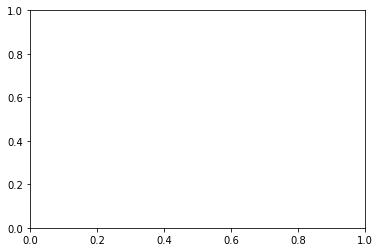

In [24]:
x_train = []

list_of_images = os.listdir('Resized_Dataset/train-resized')
for image in list_of_images:
  image = plt.imread('Resized_Dataset/train-resized/' + image)
  plt.grid(False)
  x_train.append(image)
len(x_train)

601

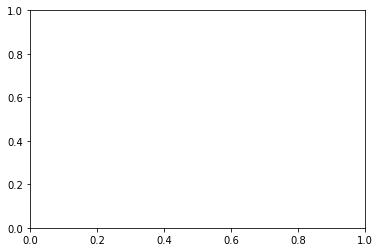

In [44]:
x_test = []

test_path = ('Resized_Dataset/test-resized/')

for image in x_test_features:
  # image.rfind : removes '.jpeg'
  image_path =test_path + image[:image.rfind('.jpeg')]

  if os.path.isfile(image_path + '.png'):
    image = plt.imread(image_path + '.png')
    plt.grid(False)
    x_test.append(image)
len(x_test)

In [27]:
x_train = np.array(x_train, np.float16) / 255.0
y_train = np.array(y_train)
print(len(x_train), len(y_train), x_train.shape, y_train.shape)

x_test = np.array(x_test, np.float16) / 255.0
y_test = np.array(y_test)
print(len(x_test), len(y_test), x_test.shape, y_test.shape)

5309 5309 (5309, 256, 256, 4) (5309, 2)
601 601 (601, 256, 256, 4) (601, 2)


In [29]:
# https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb
# https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet/#6 
bnmomentum=0.9
def fire(x, squeeze, expand):
  y = Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
  y = BatchNormalization(momentum=bnmomentum)(y)
  y1 = Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
  y1 = BatchNormalization(momentum=bnmomentum)(y1)
  y3 = Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  y3 = BatchNormalization(momentum=bnmomentum)(y3)
  return concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)
x = Input(shape=[256, 256, 4])
# y = fire_module(squeeze=24, expand=48)(x) # squeeze is less than expand
# y = fire_module(squeeze=32, expand=64)(y)


y = Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
y = BatchNormalization(momentum=bnmomentum)(y)
y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 96)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 128)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 96)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = GlobalAveragePooling2D()(y)
y = Dense(2, activation='softmax')(y)
model = tf.keras.Model(x, y)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 24) 792         batch_normalization[0][0]        
______________________________________________________________________________________________

In [32]:
validation_split = 0.25
history = model.fit(x_train, y_train, epochs = 5, validation_split=validation_split)

Epoch 1/5
125/125 [==============================] - 32s 254ms/step - loss: 0.6125 - accuracy: 0.7081 - val_loss: 0.5666 - val_accuracy: 0.7477
Epoch 2/5
125/125 [==============================] - 29s 235ms/step - loss: 0.5771 - accuracy: 0.7408 - val_loss: 0.6838 - val_accuracy: 0.7477
Epoch 3/5
125/125 [==============================] - 30s 239ms/step - loss: 0.5773 - accuracy: 0.7410 - val_loss: 0.5663 - val_accuracy: 0.7477
Epoch 4/5
125/125 [==============================] - 30s 244ms/step - loss: 0.5746 - accuracy: 0.7413 - val_loss: 0.5684 - val_accuracy: 0.7477
Epoch 5/5
125/125 [==============================] - 31s 244ms/step - loss: 0.5742 - accuracy: 0.7413 - val_loss: 0.5695 - val_accuracy: 0.7477


19/19 [==============================] - 2s 101ms/step - loss: 0.6686 - accuracy: 0.6489
0.6686303019523621 0.6489184498786926


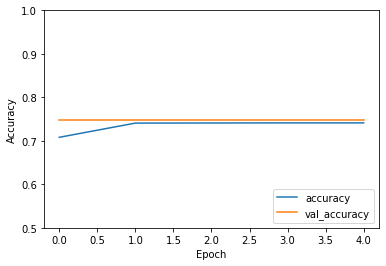

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test)
print(test_loss, test_acc)